In [1]:
import numpy as np
import pandas as pd
import math
from pandas import Series, DataFrame
from scipy import stats
from scipy.stats import (spearmanr,skew)
from pylab import rcParams
import seaborn as sb
import matplotlib.pyplot as plt
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn import linear_model
from sklearn.linear_model import (LinearRegression,Ridge,RidgeCV,LassoCV,ElasticNet,ElasticNetCV,Lasso,LassoLarsCV)
from sklearn.decomposition import PCA
from sklearn.svm import SVR

from sklearn.preprocessing import (scale,LabelEncoder)
from collections import Counter
from sklearn.model_selection import(cross_val_score,cross_val_predict,train_test_split,StratifiedKFold,GridSearchCV,KFold,RandomizedSearchCV)
from sklearn.feature_selection import(SelectKBest,VarianceThreshold,chi2)
from sklearn.ensemble import(RandomForestRegressor,RandomForestClassifier,GradientBoostingRegressor)
from sklearn.metrics import(mean_absolute_error,mean_squared_error,r2_score,explained_variance_score)
from stacking import stacking_regression

C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Initial Data Processing#
Data was pre-processed in R, additional formatting completed below.

In [404]:
#Read In Data
nullandvoid = pd.read_csv('clean_final.csv')

In [405]:
#print(nullandvoid.loc[:,("SalePrice","Set")].tail())
#nullandvoid.loc[:,("SalePrice","Set")].head()
nullandvoid.shape

(2919, 85)

In [406]:
#Removed 4 observations that are supposed to be outliers The 5th outlier is part of the test group. 
#It would not let me submit to kaggle without this record included. I assume we keep it in. 
outlier = np.log(4000)
outlier_exclude = nullandvoid.loc[nullandvoid['Set'] == 'Train']
outlier_exclude = outlier_exclude[(outlier_exclude['GrLivArea']<outlier)]
outlier_exclude.shape

(1456, 85)

In [407]:
test_include=nullandvoid.loc[nullandvoid['Set'] == 'Test']
test_include.shape

(1459, 85)

In [408]:
complete_df = pd.concat([outlier_exclude,test_include])

In [409]:
#Create Predictor Target Variable
y_target = complete_df.loc[complete_df['Set'] == 'Train']["SalePrice"]
y_target = np.log(y_target.astype(float))
y_target_df = pd.Series.to_frame(y_target)

In [410]:
nullandvoid_ID = complete_df.loc[:,('Id','Set')]
nullandvoid_ = complete_df.copy()
nullandvoid_ = nullandvoid_.loc[complete_df['Set'] == 'Train']
nullandvoid_.drop("Id", axis = 1, inplace = True)
nullandvoid_.drop("Set", axis = 1, inplace = True)
nullandvoid_.drop('SalePrice', axis=1, inplace = True)
nullandvoid_featurelist = nullandvoid_.copy()

In [411]:
nullandvoid_featurelist.shape

(1456, 82)

# Exploratory Data Analysis

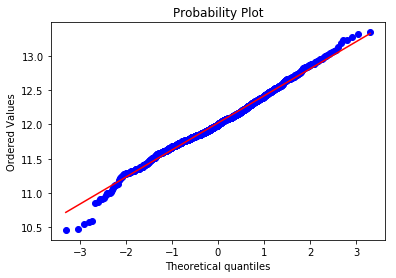

In [412]:
stats.probplot(y_target_df['SalePrice'], plot=plt)
plt.show()

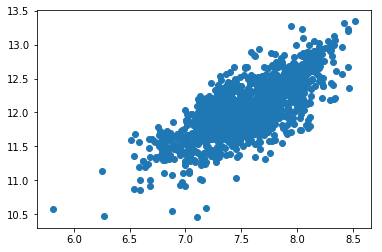

In [413]:
plt.scatter(nullandvoid_featurelist["TotalFinSF"], y_target_df["SalePrice"])
plt.show()

In [414]:
correlation = X_features.corr()
correlation.to_csv('correlation.csv')

In [415]:
correlation1 = correlation[correlation.apply(lambda x:  x > .5)]
correlation2 = correlation[correlation.apply(lambda x:  x < -.5)]

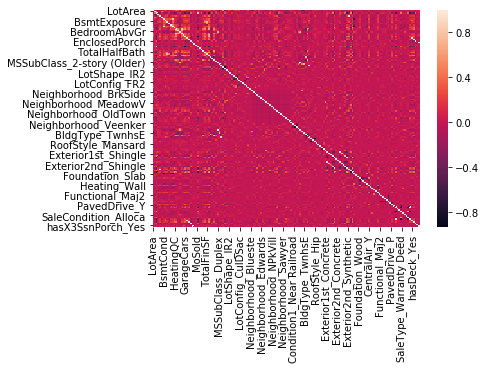

In [416]:
sb.heatmap(correlation)
plt.show()

In [417]:
nullandvoid_featurelist.loc[:,('GrLivArea','TotalFinSF','TotRmsAbvGrd','AbvGrndRoomSize')].head()

,GrLivArea,TotalFinSF,TotRmsAbvGrd,AbvGrndRoomSize
0,7.444249,7.789869,8,213.750000
1,7.140453,7.714231,6,210.333333
2,7.487734,7.728416,6,297.666667
3,7.448334,7.566828,7,245.285714
4,7.695303,7.956126,9,244.222222


In [418]:
#Adjust Feature Set (Handle Multicollinearity and Repeat Attributes)
nav_featurelist=complete_df.copy()

#Drop Lot Frontage and Keep Lot Area
nav_featurelist.drop('LotFrontage', axis = 1, inplace = True)

#Create a Quality Indicator Score 
nav_featurelist['AverageQual'] = nav_featurelist[['OverallQual', 'ExterQual', 'KitchenQual', 'BsmtQual', 'FireplaceQu']].mean(axis = 1)
nav_featurelist.drop(['OverallQual', 'ExterQual', 'KitchenQual', 'BsmtQual', 'FireplaceQu'], axis = 1, inplace = True)

#DataFrame contains Total Living Area
nav_featurelist.drop(['GrLivArea','X1stFlrSF', 'X2ndFlrSF', 'LowQualFinSF', 'BsmtFinSF2', 'BsmtFinSF1'], axis = 1, inplace = True)

#DataFrame contains Total Full and Half Bath
nav_featurelist.drop(['FullBath', 'HalfBath', 'BsmtHalfBath', 'BsmtFullBath'], axis = 1, inplace = True)

#GarageType, GarageYrBlt, GarageFinish, GarageArea, GarageQual, GarageCond
nav_featurelist.drop(['GarageType','GarageYrBlt','GarageFinish','GarageArea','GarageQual','GarageCond'], axis = 1, inplace = True)

#Already created feature YrSold - GarageYrBlt
nav_featurelist.drop('YrSold', axis = 1, inplace = True)

#AbvGrndRoomSize collinear with TotRmsAbvGrnd
#nav_featurelist.drop('AbvGrndRoomSize', axis = 1, inplace = True)


In [419]:
nav_adj_features = pd.get_dummies(nav_featurelist,drop_first=True)
nav_org_features = pd.get_dummies(complete_df,drop_first=True)

In [420]:
nav_org_features.columns
nav_org_features.loc[:,"SalePrice"]
nav_org_features.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,hasDeck_Yes,hasOpenPorch_Yes,hasEnlosedPorch_Yes,hasX3SsnPorch_Yes,hasScreenPorch_Yes,Set_Train
0,1,65.0,9.041922,7,5,1,5.283204,3,2,4,...,0,0,1,0,0,1,0,0,0,1
1,2,80.0,9.169518,6,8,1,0.000000,2,2,4,...,0,0,1,0,1,0,0,0,0,1
2,3,68.0,9.328123,7,5,0,5.093750,3,2,4,...,0,0,1,0,0,1,0,0,0,1
3,4,60.0,9.164296,7,5,0,0.000000,2,2,3,...,0,0,0,0,0,1,1,0,0,1
4,5,84.0,9.565214,8,5,1,5.860786,3,2,4,...,0,0,1,0,1,1,0,0,0,1


In [421]:
train_org_features = nav_org_features.loc[nav_org_features['Set_Train'] == 1]
test_org_features = nav_org_features.loc[nav_org_features['Set_Train'] == 0]

train_adj_features = nav_adj_features.loc[nav_adj_features['Set_Train'] == 1]
test_adj_features = nav_adj_features.loc[nav_adj_features['Set_Train'] == 0]

In [422]:
train_org_features.drop("Id", axis = 1, inplace = True)
test_org_features.drop("Id", axis = 1, inplace = True)
train_adj_features.drop("Id", axis = 1, inplace = True)
test_adj_features.drop("Id", axis = 1, inplace = True)

train_org_features.drop("Set_Train", axis = 1, inplace = True)
test_org_features.drop("Set_Train", axis = 1, inplace = True)
train_adj_features.drop("Set_Train", axis = 1, inplace = True)
test_adj_features.drop("Set_Train", axis = 1, inplace = True)

train_org_features.drop("SalePrice", axis = 1, inplace = True)
test_org_features.drop("SalePrice", axis = 1, inplace = True)
train_adj_features.drop("SalePrice", axis = 1, inplace = True)
test_adj_features.drop("SalePrice", axis = 1, inplace = True)

C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing import

In [434]:
print(train_adj_features.shape)
print(train_org_features.shape)

print(test_adj_features.shape)
print(test_org_features.shape)

(1456, 276)
(1456, 298)
(1459, 276)
(1459, 298)


### Machine Learning Algorithms ###

In [435]:
#Create the Train and Validation Data Sets (Original)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(train_org_features, y_target, test_size = .2, random_state = 42)

In [436]:
#Create the Train and Validation Data Sets (Fields Dropped)
X_train, X_test, y_train, y_test = train_test_split(train_adj_features, y_target, test_size = .2, random_state = 42)

In [437]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

### Lasso regression ###

In [438]:
lasso_para = {'alpha': [.00001, .0001, .001, .01, .1, 1]}
l_m = Lasso()
l_gs = GridSearchCV(l_m, lasso_para,cv = 5)
l_gs.fit(X_train, y_train)
print(l_gs.best_estimator_)
print(l_gs.best_score_)

C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
0.906694528809


In [439]:
lasso_para = {'alpha': np.logspace(.0001,.001)-1}
l_m = Lasso()
l_gs = GridSearchCV(l_m, lasso_para,cv = 5)
l_gs.fit(X_train, y_train)
print(l_gs.best_estimator_)
print(l_gs.best_score_)

Lasso(alpha=0.0004418179784191345, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
0.910062998167


In [440]:
l_gs.best_params_

{'alpha': 0.0004418179784191345}

In [441]:
l_gs.score(X_test, y_test)

0.90495048250964927

In [442]:
rmse(l_gs.predict(X_test),y_test)

0.12252421223647393

# Lasso 2#

In [444]:
lasso_para = {'alpha': np.logspace(.0001,.001)-1}
l_m = Lasso()
l_gs2 = GridSearchCV(l_m, lasso_para, cv = 5)
l_gs2.fit(X_train_orig, y_train_orig)
print(l_gs2.best_estimator_)
print(l_gs2.best_score_)

Lasso(alpha=0.00039950780833186705, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
0.91504484632


In [445]:
l_gs2.best_params_

{'alpha': 0.00039950780833186705}

In [446]:
#l_gs2.grid_scores_

In [447]:
l_gs2.score(X_test_orig, y_test_orig)

0.91029729078426191

In [448]:
rmse(l_gs2.predict(X_test_orig),y_test_orig)

0.11902816561349337

### Ridge regression ###

In [449]:
parameters = {'alpha': np.logspace(.00001,10)-1}
ridge_m = Ridge()
ridge_gs = GridSearchCV(ridge_m, parameters, cv = 5)
ridge_gs.fit(X_train, y_train)
print(ridge_gs.best_estimator_)
print(ridge_gs.best_score_)

Ridge(alpha=9.481348054533898, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
0.911026918804


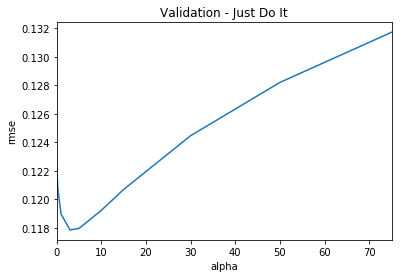

In [178]:
#Fix Plot
# cv_ridge = pd.Series(cv_ridge, index = alpha)
# cv_ridge.plot(title = "Validation - Just Do It")
# plt.xlabel("alpha")
# plt.ylabel("rmse")
# plt.show()

In [450]:
ridge_gs.score(X_test, y_test)

0.89911352048466331

In [451]:
rmse(ridge_gs.predict(X_test),y_test)

0.12623025057808823


# Ridge 2###

In [452]:
parameters = {'alpha': np.logspace(.00001,10)-1}
ridge_m = Ridge()
ridge_gs2 = GridSearchCV(ridge_m, parameters, cv = 5)
ridge_gs2.fit(X_train_orig, y_train_orig)
print(ridge_gs2.best_estimator_)
print(ridge_gs2.best_score_)

Ridge(alpha=9.481348054533898, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
0.915046712745


In [453]:
ridge_gs2.score(X_test_orig, y_test_orig)

0.90625714854666828

In [454]:
rmse(ridge_gs2.predict(X_test_orig),y_test_orig)

0.12167911448074166

### Elastic net ###

In [455]:
el_para = {'alpha': np.arange(.01,1,.1), 'l1_ratio': np.arange(0,1,.1)}
el_m = ElasticNet()
el_gs = GridSearchCV(el_m, el_para)
el_gs.fit(X_train, y_train)
print(el_gs.best_estimator_)
print(el_gs.best_score_)

# ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.0,
#       max_iter=1000, normalize=False, positive=False, precompute=False,
#       random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
# 0.911479100379

C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did no

C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.0,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
0.91150845796


C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [456]:
el_gs.score(X_test, y_test)

0.89873799870318472

### MLR ###

In [457]:
lassoreg = Lasso(0.00039950780833186705)
lassoreg.fit(X_train_orig, y_train_orig)

cols = X_train_orig.columns.tolist()
lasso_drop = list()

for i in list(np.where(lassoreg.coef_ == 0)[0]):
    lasso_drop.append(cols[i])

In [458]:
X_features_drop = X_train_orig.drop(lasso_drop, axis = 1, inplace = False)
#X_features_drop

Xtest_features_drop = X_test_orig.drop(lasso_drop, axis = 1, inplace = False)
#Xtest_features_drop

# X_train_drop, X_test_drop, y_train_drop, y_test_drop = train_test_split(X_features_drop, y_train_orig, test_size = .2, random_state = 42)

In [459]:
mlr_m = LinearRegression()
mlr_m.fit(X_features_drop, y_train_orig)
mlr_m.score(Xtest_features_drop, y_test_orig)

0.90775338566229402

In [460]:
rmse(mlr_m.predict(Xtest_features_drop),y_test)

0.12070414341716248

In [461]:
#MLR2 - with variables dropped
mlr_o = LinearRegression()
mlr_o.fit(X_train, y_train)
mlr_o.score(X_test, y_test) #model seems to be overfitting even after we reduced feature set

-1.3999720862117275e+17

### Random forest ###

In [191]:
# #Use Randomized Search for identifying parameters for Randorm Forest Model#

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 20, stop = 150, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 30, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)

{'n_estimators': [20, 34, 48, 63, 77, 92, 106, 121, 135, 150], 'max_features': ['auto'], 'max_depth': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [224]:
# rf = RandomForestRegressor()

# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# rf_random.fit(X_train, y_train)

# rf_random.best_params_

In [225]:
# #Refine Grid Search CV based on Randomized Search params for purposes of identifying optimum 
# rf_m = RandomForestRegressor()

# rf_para = [{
#   'max_depth': range(18, 23, 1),
#   'n_estimators': range(150, 300, 10),
#   'min_samples_leaf' : [5],
#   'min_samples_split': [10],
#   'max_features': ['sqrt'],
#   'random_state' : [42]
# }]

# rf_gs = GridSearchCV(estimator = rf_m, param_grid = rf_para, cv = 5, n_jobs = -1)
# rf_gs.fit(X_train, y_train)

# print(rf_gs.best_params_)
# rf_gs.best_score_

In [462]:
rf_m_orig = RandomForestRegressor()

rf_para_orig = [{
'max_depth': [17],
'n_estimators': [239],
'min_samples_leaf' : [5],
'min_samples_split': [10],
'max_features': ['sqrt']
}]

rf_gs_orig = GridSearchCV(estimator = rf_m_orig, param_grid = rf_para_orig, cv = 3, n_jobs = -1)
rf_gs_orig.fit(X_train_orig, y_train_orig)

print(rf_gs_orig.best_params_)
rf_gs_orig.best_score_

{'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 239}


0.8522486032915958

In [463]:
rmse(rf_gs_orig.predict(X_test_orig),y_test_orig)

0.15754870196869136

In [464]:
#XG Boost#
import xgboost as xgb
# XGBoost -- I did some "manual" cross-validation here but should really find
# these hyperparameters using CV. ;-)

regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.05,
                 max_depth=6,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

regr.fit(X_train, y_train)

# # Run prediction con training set to get a rough idea of how well it does.
# y_pred = regr.predict(train_df_munged)
# y_test = label_df
# rmse_xgb=rmse(y_test, y_pred)
# print("XGBoost score on training set: ", rmse_xgb)

# # Run prediction on the Kaggle test set.
# y_pred_xgb = regr.predict(test_df_munged)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.2, gamma=0.0, learning_rate=0.05,
       max_delta_step=0, max_depth=6, min_child_weight=1.5, missing=None,
       n_estimators=7200, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0.9, reg_lambda=0.6, scale_pos_weight=1,
       seed=42, silent=1, subsample=0.2)

In [465]:
rmse(regr.predict(X_test),y_test)

0.13338854722523294

In [466]:
regr1 = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.05,
                 max_depth=6,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)
regr1.fit(X_train_orig, y_train_orig)
rmse(regr1.predict(X_test_orig),y_test_orig)

0.12658340272474966

### Support vector regression ###

In [241]:
# svr_para = {'C': np.arange(4,7,1), 'epsilon': np.arange(.005,.007,.001)}
# svr_m = SVR(kernel = 'linear')
# svr_gs = GridSearchCV(svr_m, svr_para)
# svr_gs.fit(X_train_orig, y_train_orig)

In [468]:
#Tried Model with X_train_orig and results seem to be skewed 
svr_test = SVR(kernel = 'linear', C = 6, epsilon = 0.006)
svr_test.fit(X_train, y_train)
print(svr_test.score(X_test, y_test))

0.534617055734


In [469]:
svr_test.get_params

<bound method BaseEstimator.get_params of SVR(C=6, cache_size=200, coef0=0.0, degree=3, epsilon=0.006, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)>

### Gradient boosting regression ###

In [470]:
gbr_para = {'learning_rate': np.arange(.01,1,.005), 'subsample': np.arange(.1,1,.1)}
gbr_m = GradientBoostingRegressor(n_estimators = 400, min_samples_split = 10, max_depth = 2, max_features = 12)
gbr_gs = GridSearchCV(gbr_m, gbr_para)
gbr_gs.fit(X_train_orig, y_train_orig)
print(gbr_gs.best_estimator_)
print(gbr_gs.best_score_)

#0.896768865146 - X_train, y_train

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.079999999999999988, loss='ls', max_depth=2,
             max_features=12, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=400,
             presort='auto', random_state=None,
             subsample=0.80000000000000004, verbose=0, warm_start=False)
0.907251981106


### Ensembling ###

*Averaging*

In [471]:
print(X_test.shape)
print(X_test_orig.shape)


(292, 276)
(292, 298)


In [472]:
avg_test=(ridge_gs2.predict(X_test_orig) + l_gs2.predict(X_test_orig)
+ rf_gs_orig.predict(X_test_orig) + gbr_gs.predict(X_test_orig) + regr1.predict(X_test_orig))/5

In [473]:
# mlr_o.predict(X_test) 

In [474]:
rmse(avg_test,y_test)

0.12064328059174727

In [476]:
test_org_features.shape
#nullandvoid_ID.loc[nullandvoid_ID['Set'] == 'Test']["Id"]

(1459, 298)

In [484]:
test_prediction=(ridge_gs2.predict(test_org_features) + l_gs2.predict(test_org_features)
    + rf_gs_orig.predict(test_org_features) + gbr_gs.predict(test_org_features) + regr1.predict(test_org_features))/5

In [485]:
#pd.concat(nullandvoid_ID["Id"],test_prediction)
#np.exp(test_prediction)
id_ = DataFrame(nullandvoid.loc[nullandvoid['Set'] == 'Test']["Id"])
ex_ = DataFrame(np.exp(test_prediction))

#id_.reset_index()
#ex_.reset_index()
print(id_.shape)
print(ex_.shape)

(1459, 1)
(1459, 1)


In [487]:
pd.concat([id_,ex_]).to_csv("finaltest.csv") #need to fix code (cell alignment adjustment)

# *Stacking*

In [488]:
#Can someone explain the linear regression test?

models = [
    #LinearRegression().fit(X_train_orig, y_train_orig),
    
    Lasso(alpha = 0.00039950780833186705),
    
    SVR(C=6, cache_size=200, coef0=0.0, degree=3, epsilon=0.0060000000000000001, 
        gamma='auto', kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
    
    ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.0,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
    
    #Alpha had a big jump to 9.48 (ask mitch)
    Ridge(alpha=9.481348054533898, copy_X=True, fit_intercept=True, 
          max_iter=None, normalize=False, random_state=None, solver='auto', tol=0.001)
    
    ]

meta_model = LinearRegression(normalize=True)

In [ ]:
#reintroduce rmse for sake of comparison to the log formula below, which one should we be using and why?
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [489]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(np.log(y), np.log(y_pred)))

In [490]:
final_prediction = stacking_regression(models, meta_model, X_train, y_train.as_matrix(), X_test,
                                       transform_target=np.log1p, transform_pred = np.expm1, 
                                       metric=rmsle, verbose=1)

metric: [rmsle]

model 0: [Lasso]
    ----
    MEAN:   [0.01126359]

model 1: [SVR]
    ----
    MEAN:   [0.20556147]

model 2: [ElasticNet]


C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


    ----
    MEAN:   [0.00994766]

model 3: [Ridge]
    ----
    MEAN:   [0.00994486]



In [493]:
final_prediction.shape

(292,)

In [502]:
id_ = test_org_features.copy()
ex_ = DataFrame(np.exp(final_prediction))

#id_.reset_index()
#ex_.reset_index()

print(id_.shape)
print(ex_.shape) #How do we generate the prediction on the test set? What is the 'predict' function for Stacking?

(1459, 298)
(292, 1)


In [508]:
final_prediction[:5] 

array([ 12.08904455,  11.89160702,  11.74589836,  11.88297942,  11.32747078])

In [496]:
#using rmse function instead
final_prediction = stacking_regression(models, meta_model, X_train, y_train.as_matrix(), X_test,
                                       transform_target=np.log1p, transform_pred = np.expm1, 
                                       metric=rmse, verbose=1)

metric: [rmse]

model 0: [Lasso]
    ----
    MEAN:   [0.13348626]

model 1: [SVR]
    ----
    MEAN:   [2.67780601]

model 2: [ElasticNet]


C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


    ----
    MEAN:   [0.11750440]

model 3: [Ridge]
    ----
    MEAN:   [0.11748496]



C:\Users\raj-t\Anaconda2\envs\py3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [ ]:
#test_org_features 
#test_adj_features -> Potentially test other submissions with adjusted test set. 